# Введение в анализ данных (первый семестр)
## Домашнее задание №2 - Ускорение k-means


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.metrics.pairwise import distance_metrics

from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from line_profiler import LineProfiler

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

%load_ext Cython

In [2]:
#%reload_ext Cython

In [3]:
def profile_print(func_to_call, *args):
    profiler = LineProfiler()
    profiler.add_function(func_to_call)
    profiler.runcall(func_to_call, *args)
    profiler.print_stats()

Функция для проверки метода k-means на модельных данных

In [4]:
def check_kmeans(func, *args, **kwargs):
    
    X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=42)

    sc = StandardScaler()
    X = sc.fit_transform(X)
    if 'plot' in kwargs:
        plot = kwargs['plot']
        kwargs.pop('plot')
    else:
        plot = False
    
    if 'km' in kwargs:
        km = kwargs['km']
        func(X)
        labels, centroids, n_iters = km.labels, km.centroids, km.n_iters
    else:
        labels, centroids, n_iters = func(X, **kwargs)

    print "Number of iterations:", n_iters
    print "Labels:", np.unique(labels)

    if plot:
        plt.scatter(X[:,0], X[:, 1], c=labels)
        plt.scatter(centroids[:,0], centroids[:,1], c='red', marker='x', s=140, linewidths=2)
    return

## Подготовка тестовых данных

In [5]:
df_sns = pd.read_csv('snsdata.csv', sep=',')

# delete all features except 36 keywords
df_sns_restricted = df_sns[df_sns.columns[4:]]

# normalize
df_sns_restricted = (df_sns_restricted - df_sns_restricted.mean()).div(df_sns_restricted.std())
df_sns_restricted.head()

,basketball,football,soccer,softball,volleyball,swimming,cheerleading,baseball,tennis,sports,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
1,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,1.067374,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
2,-0.332212,1.060031,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,2.027874,-0.220399,-0.174905
3,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,-0.487306,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,-0.220399,-0.174905
4,-0.332212,-0.357691,-0.24287,-0.217924,-0.223666,-0.259966,-0.207324,-0.201127,-0.168936,-0.297118,...,-0.050936,-0.369909,2.273635,-0.314193,-0.201473,-0.183029,-0.294788,-0.261526,2.285084,2.719271


## Имплементация K-means с использованием векторных операций NumPy

### Имплементация в виде функции

In [6]:
def k_means(X, n_clusters=2, metric='euclidean', max_iter=1000, random_state=None):
    # Инициализация генератора случайных чисел
    np.random.seed(random_state)

    # Массив с метками кластеров для каждого объекта из X
    labels = np.zeros(X.shape[0], dtype=int)
    labels.fill(-1)

    # Массив с центроидами кластеров
    centroids = np.random.random((n_clusters, X.shape[1]))
    min_values = np.min(X, axis=0) 
    values_ranges = np.max(X, axis=0) - min_values
    centroids = min_values + (values_ranges * centroids)

    # init tmp (old) centroids and labels
    old_centroids = centroids.copy()
    old_labels = labels.copy()

    # loop over iterations and while centroids not found
    n_iters = 0
    for n_iters in xrange(max_iter):
        # store prev iteration params
        np.copyto(old_centroids, centroids)
        np.copyto(old_labels, labels)

        # for each sample, give it a label of nearest centroid
        labels = distance_metrics()[metric](X, centroids).argmin(axis=1)

        # for each cluster, compute average, it will be a new centroid   
        for c in xrange(centroids.shape[0]):
            centroids[c] = np.average(X[(labels == c)], axis=0)

        # if no points assigned to centroid, do not change centroid coords
        nan_rows = np.isnan(centroids).any(axis=1)
        centroids[nan_rows] = old_centroids[nan_rows]

        # check if clusters change, if not, stop
        if np.array_equal(labels, old_labels):
            break
    
    return labels, centroids, n_iters

### Имплементация в виде класса

In [7]:
class Kmeans(BaseEstimator, ClusterMixin): 
    
    def __init__(self, n_clusters=2, metric='euclidean', max_iter=1000, random_state=None):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максимальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """
        
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        self.n_iters = None
        self.n_iters = None
        self.X = None
        self.labels = None
        self.centroids = None
        self._check_params()
        
    def _check_params(self):
        if self.max_iter < 0:
            raise ValueError("number of iterations (set %d) must be non-negative" % (self.max_iter))
        if self.n_clusters < 1:
            raise ValueError("number of clusters (set %d) must be positive" % (self.n_clusters))
        if self.metric not in distance_metrics().keys():
            raise ValueError("specified metric (%s) is not supported. List of supported metrics:\n%s" % 
                             (self.metric, ', '.join(distance_metrics().keys())))
        
    def _check_and_prepare_X(self, X):
        if not isinstance(X, np.ndarray) and not isinstance(X, pd.DataFrame):
            raise ValueError("X must have numpy.ndarray or pandas.DataFrame type, but given X has type " +  str(type(X)))
        if self.n_clusters > X.shape[0]:
            raise ValueError("number of clusters (set %d) must be not greater than number of samples (set %d)" % 
                             (self.n_clusters, X.shape[0]))
        if isinstance(X, pd.DataFrame):
            self.X = X.as_matrix()
        else:
            self.X = X
            
    def _check_if_fitted(self):
        if self.centroids is None:
            raise RuntimeError("clustering object is not fitted yet, so centroids are not set")
                             
    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        :X - матрица наблюдений (numpy.ndarray или pandas.DataFrame)
        :y - вектор меток (данный параметр не используется в обучении без учителя)
        """
        
        # Проверяем входной датасет и подготавливаем его к обработке
        self._check_and_prepare_X(X)
        
        self.labels, self.centroids, self.n_iters = k_means(self.X, self.n_clusters, self.metric, 
                                                            self.max_iter, self.random_state)
        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера
        
        Возвращает метку ближайшего кластера для каждого объекта
        """
        # Проверяем входной датасет  подготавливаем его к обработке
        self._check_and_prepare_X(X)
        
        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.zeros(self.X.shape[0], dtype=int)
        self.labels.fill(-1)
        
        self._check_if_fitted()
        self.labels = distance_metrics()[self.metric](X, self.centroids).argmin(axis=1)
        
        return self.labels

### Проверка корректности имплементаций

In [22]:
km = Kmeans(n_clusters=3, random_state=666)
check_kmeans(km.fit, km=km, plot=False)

Number of iterations: 2
Labels: [0 1 2]


Number of iterations: 2
Labels: [0 1 2]


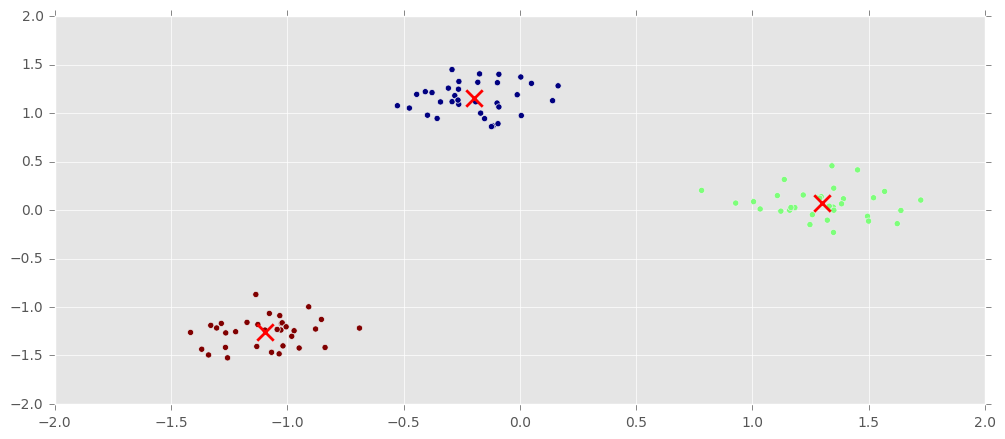

In [23]:
check_kmeans(k_means, n_clusters=3, random_state=666, plot=True)

### Замер времени работы K-means на реальных данных

In [10]:
# found random states and non-empty clusters for them
# [0 1 2 4 5 7 8] 1480
# [0 1 2 3 5 6 7] 1008
X = df_sns_restricted.as_matrix()
km = Kmeans(n_clusters=9, random_state=1008)
%timeit -n 1 km.fit(X)
%timeit -n 1 k_means(X, n_clusters=9, random_state=1008)
lbls, cntrds, ntrs = k_means(X, n_clusters=9, random_state=1008)
print "Class:", np.unique(km.labels), km.n_iters
print "Func: ", np.unique(lbls), ntrs
print "Number of iterations in class:", km.n_iters
print "Number of iterations in func: ", ntrs

C:\Dev\Python\2\Anaconda2\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


1 loop, best of 3: 815 ms per loop
1 loop, best of 3: 788 ms per loop
Class: [0 1 2 3 5 6 7] 42
Func:  [0 1 2 3 5 6 7] 42
Number of iterations in class: 42
Number of iterations in func:  42


Из замеров времени видно, что разница между функцией и классом по времени незначительная. Поэтому, в дальнейшем будем модифицировать функцию, т.к. это более удобно.

## Профилирование функции для нахождения наиболее ёмких в вычислении участков 

In [11]:
profile_print(k_means, X, 9, 'euclidean', 1000, 1008)

Timer unit: 5.70181e-07 s

Total time: 1.08991 s
File: <ipython-input-6-22bc051143a0>
Function: k_means at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def k_means(X, n_clusters=2, metric='euclidean', max_iter=1000, random_state=None):
     2                                               # Инициализация генератора случайных чисел
     3         1           36     36.0      0.0      np.random.seed(random_state)
     4                                           
     5                                               # Массив с метками кластеров для каждого объекта из X
     6         1           61     61.0      0.0      labels = np.zeros(X.shape[0], dtype=int)
     7         1           28     28.0      0.0      labels.fill(-1)
     8                                           
     9                                               # Массив с центроидами кластеров
    10         1           46     46.0      0.0      ce

Из профилирования видно, что дольше всего вычисляются: <br>
1) Метки классов (точнее, расстояния, среди которых берётся минимум): <br>
labels = distance_metrics()[metric](X, centroids).argmin(axis=1) - занимает примерно 47-49% всего времени выполнения <br>
2) Новые центроиды: <br>
centroids[c] = np.average(X[(labels == c)], axis=0) - занимает 49-51% всего времени выполнения <br>

Также из профилирования видно, что оптимизировать с помощью numpy дальше уже не представляется возможным, так как бОльшую часть времени выполнения занимают уже векторизованные операции.

## Имплементация k-means с использованием NumPy и Cython

Из профилирования векторизованной реализации k-means видно, что в дальнейшей оптимизации нуждаются вычисление расстояний, вычисление argmin, и вычисление среднего, так как эти операции занимают примерно 98% всего времени выполнения.

Для вычисления расстояний делаем допущение, что метрика выбирается 'euclidean'.

Квадрат евклидова расстояния между матрицами X и cetnroids равен:<br>
(X - centroids)^2 = X\`X - 2\*centroids\`X + centroids\`centroids<br>
Мы будем искать минимальные расстояния (т.к. ищем ближайшие центроиды для каждого объекта). Заметим, что при фиксированном X:<br>
min(X\`X - 2\*centroids\`X + centroids\`centroids) достигается при max(centroids\`X - 0.5\*centroids\`centroids),<br>
где A\` - транспонированная матрица A

In [12]:
# if use openmp, use theese compile args
# for gcc
#%%cython --compile-args=-fopenmp --link-args=-fopenmp --force
# for msvc
#%%cython --compile-args=/fopenmp --link-args=/fopenmp --force -a

In [24]:
%%cython -a
cimport cython
from cython.parallel cimport prange, parallel
import numpy as np
cimport numpy as cnp
from numpy cimport ndarray as array
from libc.math cimport pow as powc

ctypedef cnp.float64_t FLOAT64_t
ctypedef cnp.int64_t INT64_t
ctypedef Py_ssize_t INT_t

FLOAT64 = np.float64
INT64 = np.int64

@cython.wraparound(False)
@cython.boundscheck(False)
@cython.nonecheck(False)
@cython.cdivision(True)
cpdef tuple k_means_cython(array[FLOAT64_t, ndim=2] X, INT_t n_clusters=2, INT_t max_iter=1000, INT_t random_state=-1):
    
    # typed variables, used in k_means
    cdef INT_t n_samples = X.shape[0]
    cdef INT_t n_features = X.shape[1]
    cdef INT_t centroid, feature, sample, n_iters
    cdef INT64_t closest_cluster
    cdef FLOAT64_t cur_dist, min_dist
    cdef array[INT64_t, ndim=1] labels, old_labels, clusters_sizes
    cdef array[FLOAT64_t, ndim=2] centroids, old_centroids, distances
    cdef array[FLOAT64_t, ndim=1] min_values, values_ranges, min_dists, centroids_squared_norms
    
    # initialize random seed
    if random_state != -1:
        np.random.seed(random_state)
    else:
        np.random.seed(None)
    
    # randomly initialize cenroids
    centroids = np.random.random((n_clusters, n_features))
    min_values = np.min(X, axis=0) 
    values_ranges = np.max(X, axis=0) - min_values
    centroids = min_values + (values_ranges * centroids)
    old_centroids = np.empty((n_clusters, n_features), dtype=FLOAT64)
    
    # initialize labels all with -1
    labels = np.ones(n_samples, dtype=INT64) * (-1)
    old_labels = np.empty(n_samples, dtype=INT64)
    
    # initialize other variables as empty arrays (allocate memory for it)
    min_dists = np.empty(n_samples, dtype=FLOAT64)
    clusters_sizes = np.empty(n_clusters, dtype=INT64)
    distances = np.empty((n_samples, n_clusters), dtype=FLOAT64)
    centroids_squared_norms = np.empty(n_clusters, dtype=FLOAT64)   

    # main loop of kmeans
    for n_iters in xrange(max_iter):
        
        # init tmp (old) centroids and labels
        old_centroids[:] = centroids
        old_labels[:] = labels
        
        # compute centroids`*X
        np.dot(X, centroids.T, out=distances)

        # compute centroid`*centroid
        #for centroid in xrange(n_clusters):
        for centroid in prange(n_clusters, nogil=True):
            centroids_squared_norms[centroid] = 0.0
            for feature in xrange(n_features):
                centroids_squared_norms[centroid] += powc(centroids[centroid, feature], 2)

        # compute labels
        #for sample in xrange(n_samples):
        for sample in prange(n_samples, nogil=True):
            min_dist = distances[sample, 0] - (0.5 * centroids_squared_norms[0])
            closest_cluster = 0
            for centroid in xrange(1, n_clusters):
                cur_dist = distances[sample, centroid] - (0.5 * centroids_squared_norms[centroid])
                if cur_dist > min_dist:
                    min_dist = cur_dist
                    closest_cluster = centroid
            labels[sample] = closest_cluster
            min_dists[sample] = min_dist

        # Check if labels changed
        if np.array_equal(labels, old_labels):
            break
        else:
            # compute new centroids
            # count sizes of clusters
            clusters_sizes = np.zeros(n_clusters, dtype=INT64)
            for sample in xrange(n_samples):
                clusters_sizes[labels[sample]] += 1
                
            # compute new centroids as means of clusters
            #for feature in xrange(n_features):
            for feature in prange(n_features, nogil=True):
                for centroid in xrange(n_clusters):
                    # don`t change centroid with empty cluster
                    if clusters_sizes[centroid] > 0:
                        centroids[centroid, feature] = 0.0
                for sample in xrange(n_samples):
                    centroids[labels[sample], feature] += X[sample, feature]
                for centroid in xrange(n_clusters):
                    if clusters_sizes[centroid] > 0:
                        centroids[centroid, feature] /= clusters_sizes[centroid]
    
    return labels, centroids, n_iters

Как видно из аннотации, жёлтых строк внутри основного цикла мало. Были использованы векторные операции np.dot и np.array_equal, т.к. они работают быстрее, чем "наивная" реализация. Операция копирования элементов также реализована эффективнее, чем поэлементное копирование (в начале основного цикла алгоритма). Также np.zeros даёт маленький, но прирост в скорости по сравнению с поэлементным заполнением массива. Остальные "жёлтые" строки располагаются вне цикла работы алгоритма, и не влияют на прирост производительности.

### Проверка корректности реализации с Cython

Number of iterations: 2
Labels: [0 1 2]


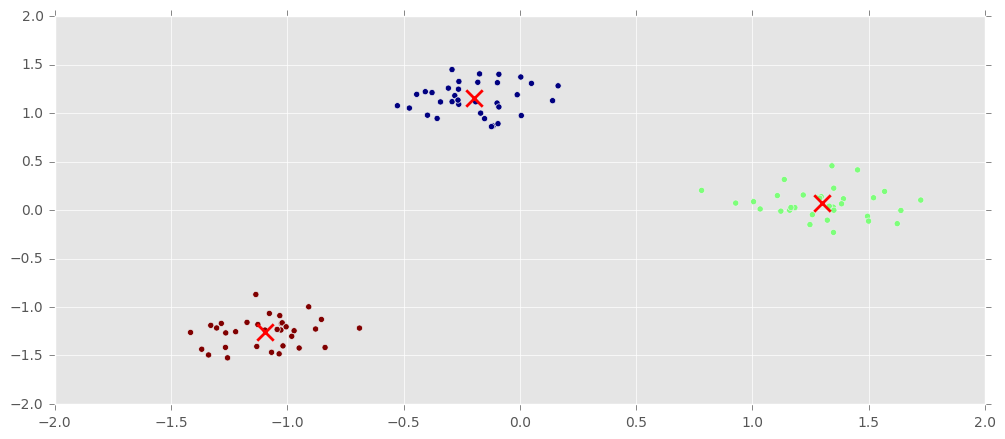

In [21]:
check_kmeans(k_means_cython, n_clusters=3, random_state=666, plot=True)

Убедимся, что накладные расходы на взаимодействие с Python малы, посмотрев результат профилирования функции.

In [15]:
import pstats, cProfile
cProfile.runctx("k_means_cython(X, 9, 1000, 1008)", globals(), locals(), "Profile.prof")

s = pstats.Stats("Profile.prof")
s.strip_dirs().sort_stats("time").print_stats()

Sat Apr 01 04:15:34 2017    Profile.prof

         442 function calls in 0.325 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.318    0.318    0.325    0.325 {_cython_magic_7b2df9782ea800a57aabaf725b24978f.k_means_cython}
       45    0.004    0.000    0.004    0.000 {method 'reduce' of 'numpy.ufunc' objects}
       43    0.003    0.000    0.005    0.000 numeric.py:2476(array_equal)
      129    0.000    0.000    0.000    0.000 numeric.py:414(asarray)
       43    0.000    0.000    0.001    0.000 {method 'all' of 'numpy.ndarray' objects}
      129    0.000    0.000    0.000    0.000 {numpy.core.multiarray.array}
       43    0.000    0.000    0.001    0.000 _methods.py:40(_all)
        1    0.000    0.000    0.000    0.000 {numpy.core.multiarray.copyto}
        1    0.000    0.000    0.001    0.001 fromnumeric.py:2200(amax)
        1    0.000    0.000    0.002    0.002 fromnumeric.py:2300(amin)
        1    0

<pstats.Stats instance at 0x000000000DA6BE08>

### Замер времени работы K-means на реальных данных

In [16]:
%%timeit -n 1
k_means_cython(X, 9, 1000, 1008)

1 loop, best of 3: 277 ms per loop


In [17]:
labels, centroids, n_iters = k_means_cython(X, 9, 1000, 1008)
print np.unique(labels), centroids.shape, n_iters

[0 1 2 3 5 6 7] (9L, 36L) 42


Как видно из замеров времени, удалось добиться небольшого прироста по времени по сравнению с веркторизированной реализацией: примерно в 2 раза, однако удалось сделать это за счёт оптимизации алгоритма подсчёта минимальных расстояний от матрицы наблюдений до центроид. Сравнив количество итераций на одном и том же random_state, а также полученные метки классов, убеждаемся, что кластеризация прошла аналогично как для векторизованной формы, так и для версии с использованием Cython.